In [1]:
import torch
from torch import nn
from torchvision import transforms as tfs
from torch.utils.data import DataLoader, Dataset
import os
import cv2
import pdb
from torch.nn import functional as F
from datetime import datetime
import numpy as np
from PIL import Image

In [2]:
classes = ['background','apple', 'banana', 'bread', 'bun', 'doughnut', 'egg', 'fired_dough_twist', 'grape', 'lemon', 'litchi', 'mango', 
          'mooncake', 'orange', 'pear', 'peach', 'plum', 'qiwi', 'sachima', 'tomato', 'coin']

# RGB color for each class
colormap = [[0,0,0],[255,0,0],[227, 207, 87], [165, 42, 42], [255, 245, 238],
            [255, 215, 0],[205,133,63],[139,69,19],[128,0,128],[255,127,132],
            [255,69,0],[255,255,0],[215,105,30],[255,165,0],
            [255,227,132],[220,20,60],[139,0,0],[34,139,34],
            [255,255,240],[255,99,71],[0, 0, 255]]

In [3]:
cm2lbl = np.zeros(256**3) # 每个像素点有 0 ~ 255 的选择，RGB 三个通道
for i,cm in enumerate(colormap):
    cm2lbl[(cm[0]*256+cm[1])*256+cm[2]] = i # 建立索引

def image2label(im):
    data = np.array(im, dtype='int32')
    idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]
    return np.array(cm2lbl[idx], dtype='int64') # 根据索引得到 label 矩阵

In [4]:
def img_transforms(im, label):
    im_tfs = tfs.Compose([
        tfs.Resize((800, 600)),
        tfs.ToTensor(),
        tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    im = im_tfs(im)
    label = label.resize((600, 800))
    label = image2label(label)
    label = torch.from_numpy(label)
    return im, label

In [5]:
class VOCSegDataset(Dataset):
    '''
    voc dataset
    '''
    def __init__(self, train, transforms, data_list,data_path, label_list, label_path):
        self.transforms = transforms
        self.data_list = data_list
        self.data_path = data_path
        self.label_path = label_path
        self.label_list = label_list
        print('Read ' + str(len(self.data_list)) + ' images')
        
        
    def __getitem__(self, idx):
        img = self.data_list[idx]
        label = self.label_list[idx]
        img = Image.open(self.data_path + img)
        label = Image.open(self.label_path + label).convert('RGB')
        img, label = self.transforms(img, label)
        return img, label
    
    def __len__(self):
        return len(self.data_list)

In [6]:
train_data_list = os.listdir('./train_image')
train_data_path = './train_image/'
train_label_list = os.listdir('./train_label')
train_label_path = './train_label/'

test_data_list = os.listdir('./test_image')
test_data_path = './test_image/'
test_label_list = os.listdir('./test_label')
test_label_path = './test_label/'
voc_train = VOCSegDataset(True, img_transforms, train_data_list, train_data_path, train_label_list, train_label_path)
voc_test = VOCSegDataset(False, img_transforms, test_data_list, test_data_path, test_label_list, test_label_path)

train_data = DataLoader(voc_train, 2, shuffle=True)
test_data = DataLoader(voc_test, 4, shuffle = False)

Read 2001 images
Read 854 images


In [7]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN,self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.max_pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.max_pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, 1, 1)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.max_pool3 = nn.MaxPool2d(2, 2)
        self.deconv1 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.debatch1 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.debatch2 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 4, 2, 1)
        self.debatch3 = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, 21, 1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.batch_norm1(x)
        x = self.max_pool1(x)
        x1 = x
        x = self.conv2(x)
        x = F.relu(x)
        x = self.batch_norm2(x)
        x = self.max_pool2(x)
        x2 = x
        x = self.conv3(x)
        x = F.relu(x)
        x = self.batch_norm3(x)
        x = self.max_pool3(x)
        
        
        x = self.deconv1(x)
        x = F.relu(x)
        x += x2
        x = self.debatch1(x)
        x = self.deconv2(x)
        x = F.relu(x)
        x = self.debatch2(x)
        x = x + x1
        x = self.deconv3(x)
        x = F.relu(x)
        x = self.debatch3(x)
        x = self.classifier(x)
        return x

In [8]:
fcn_net = FCN().cuda()
optimizer = torch.optim.SGD(fcn_net.parameters(), lr = 0.01)
criterion = nn.NLLLoss().cuda()

In [9]:
def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist


def label_accuracy_score(label_trues, label_preds, n_class):
    """Returns accuracy score evaluation result.
      - overall accuracy
      - mean accuracy
      - mean IU
      - fwavacc
    """
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc

In [10]:
for e in range(3):
    train_loss = 0
    train_acc = 0
    train_acc_cls = 0
    train_mean_iu = 0
    train_fwavacc = 0
    
    prev_time = datetime.now()
    net = fcn_net.train()
    for data in train_data:
        im = data[0].cuda()
        label = data[1].cuda()
        # forward
        out = net(im)
        out = F.log_softmax(out, dim=1) # (b, n, h, w)
        loss = criterion(out, label)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
        
        label_pred = out.max(dim=1)[1].data.cpu().numpy()
        label_true = label.data.cpu().numpy()
        for lbt, lbp in zip(label_true, label_pred):
            acc, acc_cls, mean_iu, fwavacc = label_accuracy_score(lbt, lbp, 21)
            train_acc += acc
            train_acc_cls += acc_cls
            train_mean_iu += mean_iu
            train_fwavacc += fwavacc
        
    net = fcn_net.eval()
    eval_loss = 0
    eval_acc = 0
    eval_acc_cls = 0
    eval_mean_iu = 0
    eval_fwavacc = 0
    for data in test_data:
        im = data[0].cuda()
        label = data[1].cuda()
        # forward
        out = net(im)
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, label)
        eval_loss += loss.data.item()
        
        label_pred = out.max(dim=1)[1].data.cpu().numpy()
        label_true = label.data.cpu().numpy()
        for lbt, lbp in zip(label_true, label_pred):
            acc, acc_cls, mean_iu, fwavacc = label_accuracy_score(lbt, lbp, 21)
            eval_acc += acc
            eval_acc_cls += acc_cls
            eval_mean_iu += mean_iu
            eval_fwavacc += fwavacc
        
    cur_time = datetime.now()
    h, remainder = divmod((cur_time - prev_time).seconds, 3600)
    m, s = divmod(remainder, 60)
    epoch_str = ('Epoch: {}, Train Loss: {:.5f}, Train Acc: {:.5f}, Train Mean IU: {:.5f}, \
Valid Loss: {:.5f}, Valid Acc: {:.5f}, Valid Mean IU: {:.5f} '.format(
        e, train_loss / len(train_data), train_acc / len(voc_train), train_mean_iu / len(voc_train),
        eval_loss / len(test_data), eval_acc / len(voc_test), eval_mean_iu / len(voc_test)))
    time_str = 'Time: {:.0f}:{:.0f}:{:.0f}'.format(h, m, s)
    print(epoch_str + time_str)

/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


Epoch: 0, Train Loss: 0.93179, Train Acc: 0.85361, Train Mean IU: 0.04468, Valid Loss: 0.58048, Valid Acc: 0.90580, Valid Mean IU: 0.05006 Time: 0:6:4
Epoch: 1, Train Loss: 0.55765, Train Acc: 0.90780, Train Mean IU: 0.05026, Valid Loss: 0.57202, Valid Acc: 0.90545, Valid Mean IU: 0.05020 Time: 0:6:1
Epoch: 2, Train Loss: 0.54848, Train Acc: 0.90786, Train Mean IU: 0.05112, Valid Loss: 0.56157, Valid Acc: 0.90568, Valid Mean IU: 0.05039 Time: 0:5:58


In [12]:
import matplotlib.pyplot as plt

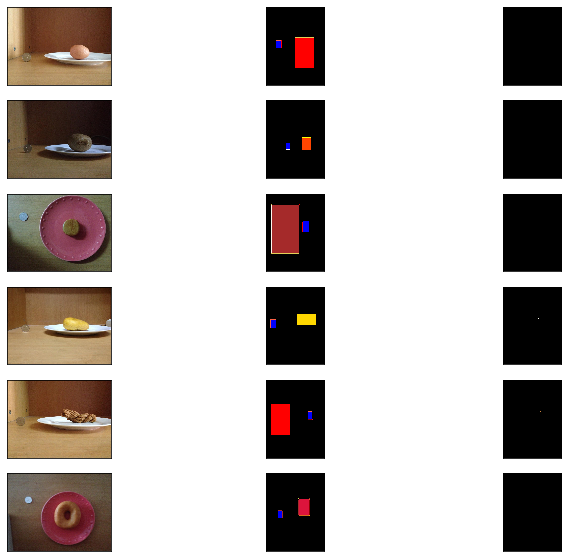

In [15]:
cm = np.array(colormap).astype('uint8')

def predict(im, label): # 预测结果
    im = im.unsqueeze(0).cuda()
    out = net(im)
    pred = out.max(1)[1].squeeze().cpu().data.numpy()
    pred = cm[pred]
    return pred, cm[label.numpy()]


_, figs = plt.subplots(6, 3, figsize=(12, 10))
for i in range(6):
    test_data, test_label = voc_test[i]
    pred, label = predict(test_data, test_label)
    figs[i, 0].imshow(Image.open('./test_image/' + voc_test.data_list[i]))
    figs[i, 0].axes.get_xaxis().set_visible(False)
    figs[i, 0].axes.get_yaxis().set_visible(False)
    figs[i, 1].imshow(label)
    figs[i, 1].axes.get_xaxis().set_visible(False)
    figs[i, 1].axes.get_yaxis().set_visible(False)
    figs[i, 2].imshow(pred)
    figs[i, 2].axes.get_xaxis().set_visible(False)
    figs[i, 2].axes.get_yaxis().set_visible(False)